# P3 - Clasificación en texto

Un problema muy complejo, en el cual actualmente se esta avanzando a pasos de gigantes en comparación con los avances de hace unos cuantos años, es en la comprenhension de texto, o de lenguaje natural en general. Nuestra manera de construir significado a partir de las palabras es mucho más compleja de lo que nos damos cuenta y supone un gran grado de conocimiento previo que hemos adquirido a lo largo de nuestras vidas. Lograr que una máquina de aprendizaje pueda extraer significado o interpretaciones a partir de un texto es un problema bastante actual, en el cul aún se hacen avances día a día. En esta pregunta utilizaremos una base de datos de texto, extraída de _reviews_ de peliculas de la página IMDB. Cada uno de estos _reviews_ está etiquetado como positivo o negativo. Nuestra tarea será predecir esta etiqueta a partir de la secuencia de palabras encodeadas como frecuencias de cada ejemplo.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/New-imdb-logo.png/1024px-New-imdb-logo.png"  style="height:6cm;"  />

Para esto probaremos distintas técnicas, incluyendo Perceptron, Redes Densas _feed forward_ y ensamblados. Si bien ninguna de estas aproximaciones son las usualmente utilizadas en la actualidad para procesamiento de texto (_words embeddings_, redes recurrente y redes convolucionales, entre muchos otros), esta pregunta servi´ra como buena aproximación a las problemáticas usualmente encontradas en estas técnicas y al momento de trabajar con texto.



### Paquetes a Utilizar

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.linear_model import LinearRegression
from keras.layers import Dense
from keras.models import Sequential

#### 3.a Carga de datos y preprocesamiento

Cargue los datos. Utilizaremos 45000 de los datos como entrenamiento y el resto como validación. Investigue sobre la base de los datos en cuestión y la representación de los datos cargados: ¿qué representa cada entrada de `x_tr`?

Comente ligeramente sobre los parámetros `num_words` y `skip_top`. ¿Por qué podría ser deseable eliminar las palabras más comunes?

Utilice luego la función `vectorize_sequences` para transformar los inputs del modelo. ¿Qué realiza esta función? ¿ Qué valor debería tener el parámetros `dimension` en este caso?¿Qué información perdemos y qué información preservamos en esta transformación?

In [ ]:
num_words = 500

# Cargar datos
(x_tr,y_tr), (x_val, y_val) = imdb.load_data(num_words = num_words, skip_top = 5)

**¿Qué representa cada entrada de `x_tr`?**

Cada entrada de `x_tr` corresponde a una lista, que contiene una secuencia de números. Estos números simbolizan palabras, es decir, el número 2 significa una palabra, el 200 significa otra y estan ordenadas según la sentencia. 

**Comente ligeramente los parámetros `num_words` y `skip_top`**

`num_words` corresponde al número máximo de palabras que puede contener cada ejemplo de `x_tr`, por ende, simboliza la dimension de la matriz results. `skip_top` permite omitir las N palabras más frecentes (que pueden ser no informativas)

**¿Por qué podría ser deseable eliminar las palabras más comunes?**

Si no se eliminan las palabras más frecuentes puede generar un sesgo hacia alguna predicción, por ejemplo, si existe una palabra muy recurrente en la prediccion cuando se muestra un nuevo ejemplo que contenga esa palabra predecirá lo mismo que la vez anterior, siendo que no necesariamente es verdad.


In [ ]:
# Número de columnas de matriz de x_tr y x_val
dimension = num_words

def vectorize_sequences(sequences, dimension = dimension):  # Sequences = x_tr / x_val
  results = np.zeros((len(sequences), dimension))           # Se crea matriz
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1                                # Se guarda transformación binaria
  return results

**¿Qué realiza esta función?**

La función `vectorize_sequences` permite generar una matriz binaria donde cada fila corresponde a un ejemplo de la data, mientras que cada columna corresponde a la cantidad de palabras que se tiene registro. Es decir, los ejemplos del input original corresponde a listas que contienen una secuencia de números, dichos números simbolizan una palabra. Por lo tanto, la función devuelve 1 en la posición de la palabra y 0 si no se está ocupando esta palabra. 

**¿ Qué valor debería tener el parámetros `dimension` en este caso?**

Corresponde al número de palabras

**¿Qué información perdemos y qué información preservamos en esta transformación?**

Es importante destacar que aquí se pierde el orden del input dado no se contabiliza las repeticiones.


In [ ]:
# Transformación del input
x_tr  = vectorize_sequences(x_tr, dimension)     
x_val = vectorize_sequences(x_val,dimension)

#### 3.b Perceptron (**Opcional**)
Entrene un perceptrón con activación sigmoidal, optimizador _Stochastic Gradient Descent_, por lo menos 15 _epochs_, como muestra el código siguiente. 

Discuta sobre la dimensión de `x_tr` y la cantidad de parámetros del modelo de acuerdo al método `.summary` del modelo.

Gráfique el error o el _accuracy_ según su preferencia, tanto sobre entrenamiento como validación, a medida pasan los _epochs_. Note esta información puede obternla desde `history.history`.

In [ ]:
per = Sequential()
per.add(Dense(1, activation = 'sigmoid'))
per.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = per.fit(x_tr, y_tr, epochs = 15,verbose = False,  validation_data = (x_val, y_val))

In [ ]:
# Resumen del modelo
resultados = history.history
per.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 501       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


**Comentarios:**

Se puede ver que los parametros corresponde a 501, dondes es la suma de la dimension de los inputs más el bias.

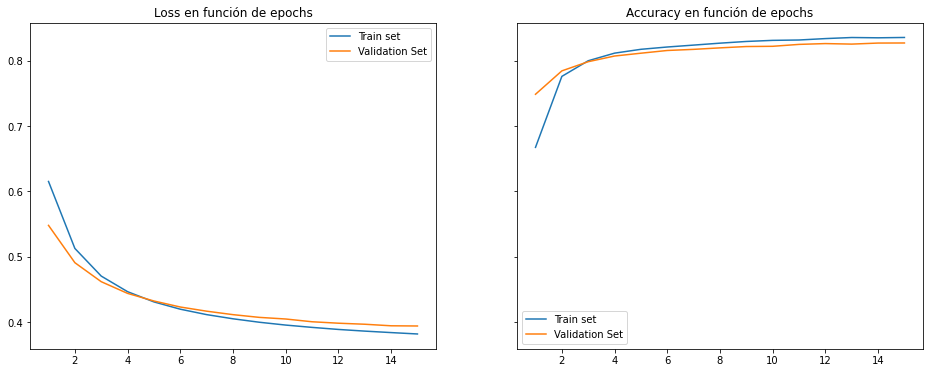

In [ ]:
# Gráficos de eeror en función de epoch
ig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados['loss'])
axs[0].plot(np.arange(1,16,1),resultados['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados['val_accuracy'])
axs[0].set_title("Loss en función de epochs")
axs[0].legend(['Train set','Validation Set'])
axs[1].set_title("Accuracy en función de epochs")
axs[1].legend(['Train set','Validation Set'])

**Comentarios**

En los gráficos se puede apreciar buenos resultados tanto para loss como accuracy.

### 3.c Red con una capa oculta

Ahora, haremos nuevamente un modelo secuencial, al cual le agregaremos una capa oculta con activación ReLu. ¿Qué realiza la función ReLu (puede ejemplificar con gráficos)?

Entrene esta red nuevamente con los mismos parámetros que la red anterior. ¿Mejoran los desempeños?¿Cuál es el número de parámetros de este modelo? Grafique nuevamente como varía la métrica a medida que pasan los epochs. ¿Alcanza a notar sobreajuste?

Cambie la función de activación por otra de su elección (e.g. $\tanh$ o activación lineal). ¿Cambia el desempeño?

Compare finalmente el desempeño con una regresión lineal. ¿Cómo hace la red para obtener representaciones no-lineales que la regresión lineal no puede obtener?¿Por qué se podría argumentar que una red neuronal densa _fedd forward_ tiene un sabor a ensamblado de regresiones lineales en un principio?

In [ ]:
# Ajuste por ReLu
red_relu = Sequential()
red_relu.add(Dense(64, activation = 'relu'))
red_relu.add(Dense(1, activation = 'sigmoid'))
red_relu.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_relu = red_relu.fit(x_tr, y_tr, epochs = 15,
                            verbose = False, validation_data = (x_val, y_val))

In [ ]:
# Resumen del modelo
resultados_relu = history_relu.history
red_relu.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                32064     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 32,129
Trainable params: 32,129
Non-trainable params: 0
_________________________________________________________________


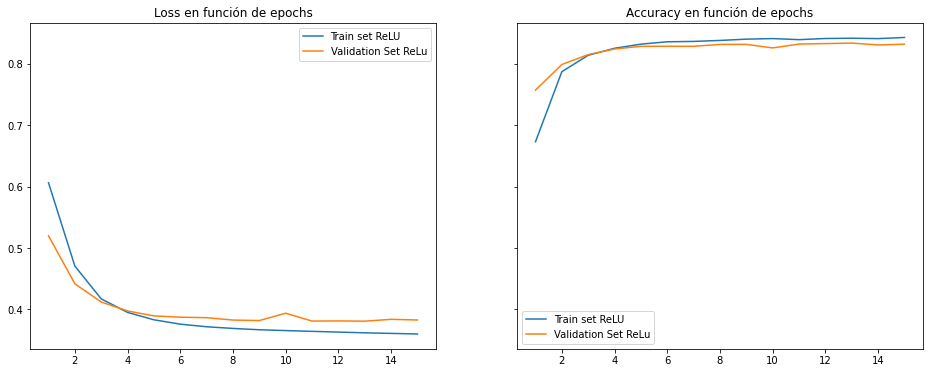

In [ ]:
# Gráficos de error en función de epoch
ig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados_relu['loss'])
axs[0].plot(np.arange(1,16,1),resultados_relu['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados_relu['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_relu['val_accuracy'])
axs[0].set_title("Loss en función de epochs")
axs[0].legend(['Train set ReLU','Validation Set ReLu'])
axs[1].set_title("Accuracy en función de epochs")
axs[1].legend(['Train set ReLU','Validation Set ReLu'])

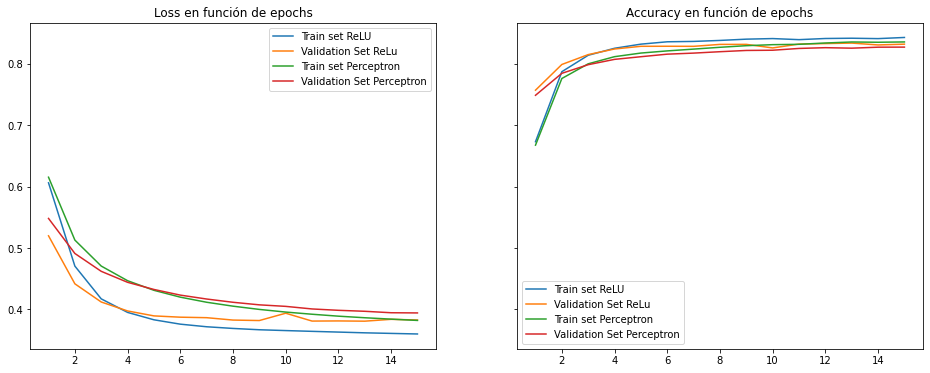

In [ ]:
# Gráficos de eeror en función de epoch
ig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados_relu['loss'])
axs[0].plot(np.arange(1,16,1),resultados_relu['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados_relu['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_relu['val_accuracy'])
axs[0].plot(np.arange(1,16,1),resultados['loss'])
axs[0].plot(np.arange(1,16,1),resultados['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados['val_accuracy'])
axs[0].set_title("Loss en función de epochs")
axs[0].legend(['Train set ReLU','Validation Set ReLu','Train set Perceptron','Validation Set Perceptron'])
axs[1].set_title("Accuracy en función de epochs")
axs[1].legend(['Train set ReLU','Validation Set ReLu','Train set Perceptron','Validation Set Perceptron'])

**Comentarios:** 

Se puede ver que se obtiene resultados similares respecto a los obtenidos con perceptron. La cantidad de parámetro aumentó considerablemente en comparación al perceptron. Esto en términos de tiempo, en ciertos problemas, puede tener un costo computacional considerable. No se alcanza a notar un gran sobreajuste.


In [ ]:
# Ajuste por ReLu
red_tanh = Sequential()
red_tanh.add(Dense(64, activation = 'tanh'))
red_tanh.add(Dense(1, activation = 'sigmoid'))
red_tanh.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_tanh = red_tanh.fit(x_tr, y_tr, epochs = 15,verbose = False, validation_data = (x_val, y_val))

In [ ]:
# Resumen del modelo
resultados_tanh = history_tanh.history
red_tanh.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                32064     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 32,129
Trainable params: 32,129
Non-trainable params: 0
_________________________________________________________________


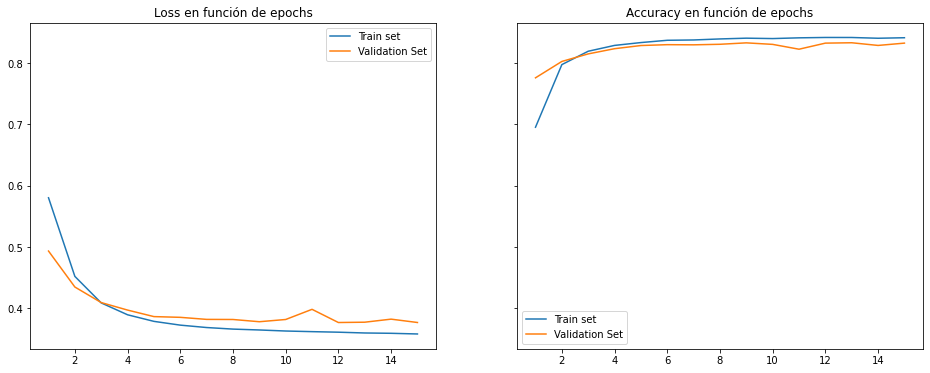

In [ ]:
# Gráficos de eeror en función de epoch
ig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados_tanh['loss'])
axs[0].plot(np.arange(1,16,1),resultados_tanh['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados_tanh['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_tanh['val_accuracy'])
axs[0].set_title("Loss en función de epochs")
axs[0].legend(['Train set','Validation Set'])
axs[1].set_title("Accuracy en función de epochs")
axs[1].legend(['Train set','Validation Set'])

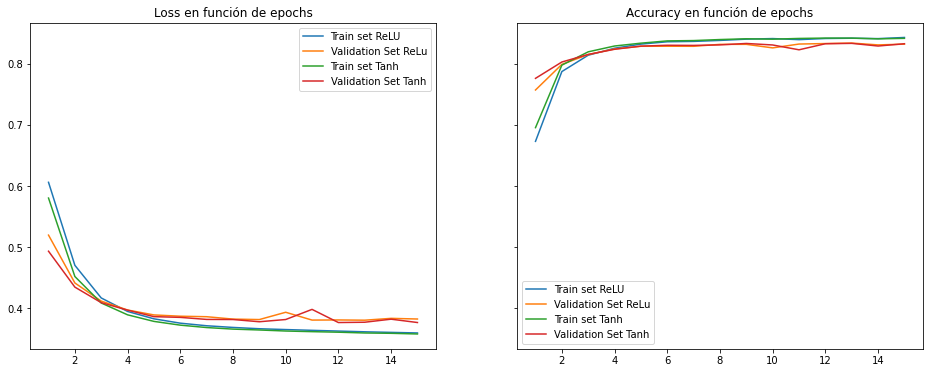

In [ ]:
# Gráficos de error en función de epoch
ig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados_relu['loss'])
axs[0].plot(np.arange(1,16,1),resultados_relu['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados_relu['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_relu['val_accuracy'])
axs[0].plot(np.arange(1,16,1),resultados_tanh['loss'])
axs[0].plot(np.arange(1,16,1),resultados_tanh['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados_tanh['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_tanh['val_accuracy'])
axs[0].set_title("Loss en función de epochs")
axs[0].legend(['Train set ReLU','Validation Set ReLu','Train set Tanh','Validation Set Tanh'])
axs[1].set_title("Accuracy en función de epochs")
axs[1].legend(['Train set ReLU','Validation Set ReLu','Train set Tanh','Validation Set Tanh'])

**Comentarios:**

Respecto a la red con ReLu, la cantidad de parámetros son los mismos porque solo se cambio la red de activación. Se puede ver una pequeña tendencia al sobreajuste en el gráfico del error. Por otro lado se puede ver que el ajuste con ambas redes son practicamente iguales.

In [ ]:
reg_linear = LinearRegression()
reg_linear.fit(x_tr,y_tr)

print('El score para la regresión lineal es',reg_linear.score(x_val,y_val),'\n')
print('El score para el Perceptron es', per.evaluate(x_val,y_val)[1],'\n')
print('El score para la red neuronal con ReLu es', red_relu.evaluate(x_val,y_val)[1],'\n')
print('El score para la red neuronal con tanh es', red_tanh.evaluate(x_val,y_val)[1],'\n')

El score para la regresión lineal es 0.452450332326889 

782/782 [==============================] - 2s 2ms/step - loss: 0.3941 - accuracy: 0.8272
El score para el Perceptron es 0.8271999955177307 

782/782 [==============================] - 2s 2ms/step - loss: 0.3826 - accuracy: 0.8320
El score para la red neuronal con ReLu es 0.8320000171661377 

782/782 [==============================] - 2s 2ms/step - loss: 0.3769 - accuracy: 0.8327
El score para la red neuronal con tanh es 0.8326799869537354 



**Comentarios:**

El desempeño de la regresión lineal está muy por debajo del desempeño de las 3 redes neuronales entrenadas, mientras que el score de las redes es muy similar obtienendo buenos resultados.


#### 3.d Exploración de número de neuronas ocultas

Utilizando la misma estrcutra de la red entrenada en la pregunta anterior, evalue como varía el _accuracy_ sobre validación y entrenamiento a medida se cambia el número de neuronas. Explore número de neuronas en potencia de 2 entre 2 y 256. En cada iteración debe considerar el mejor _accuracy_ sobre validación y el _accuracy_ de entrenamiento de ese mismo _epoch_, pues ese sería el modelo que se preferiría. 

Grafique como variaron los _accuracy_ a medida que cambió el número de neuronas y discuta.

In [ ]:
neurons        =  [2,4,8,16,32,64,128,256]
r_neurons      =  np.zeros((len(neurons),5))
r_neurons[:,0] =  neurons
k              =  0
for i in neurons: 
  print('Computando para neurona',i,'\n')

  # Entrenar ReLu
  red_relu       =  Sequential()
  red_relu.add(Dense(i, activation = 'relu'))
  red_relu.add(Dense(1, activation = 'sigmoid'))
  red_relu.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
  history_relu = red_relu.fit(x_tr, y_tr, epochs = 15,verbose = False, validation_data = (x_val, y_val))
  
  print('Red con ReLu entrenada!','\n')
  
  # Guardar accuracy
  tr_relu  = history_relu.history['accuracy']
  val_relu = history_relu.history['val_accuracy']
  r_neurons[k,1] = max(tr_relu)
  r_neurons[k,2] = max(val_relu)

  # tanh
  red_tanh       =  Sequential()
  red_tanh.add(Dense(i, activation = 'tanh'))
  red_tanh.add(Dense(1, activation = 'sigmoid'))
  red_tanh.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
  history_tanh = red_tanh.fit(x_tr, y_tr, epochs = 15,verbose = False, validation_data = (x_val, y_val))

  print('Red con tanh entrenada!','\n')
  
  # Guardar accuracy
  tr_tanh  = history_tanh.history['accuracy']
  val_tanh = history_tanh.history['val_accuracy']
  r_neurons[k,3] = max(tr_tanh)
  r_neurons[k,4] = max(val_tanh)

  k+=1

np.savetxt('r_neurons',r_neurons)

Computando para neurona 2 

Red con ReLu entrenada! 

Red con tanh entrenada! 

Computando para neurona 4 

Red con ReLu entrenada! 

Red con tanh entrenada! 

Computando para neurona 8 

Red con ReLu entrenada! 

Red con tanh entrenada! 

Computando para neurona 16 

Red con ReLu entrenada! 

Red con tanh entrenada! 

Computando para neurona 32 

Red con ReLu entrenada! 

Red con tanh entrenada! 

Computando para neurona 64 

Red con ReLu entrenada! 

Red con tanh entrenada! 

Computando para neurona 128 

Red con ReLu entrenada! 

Red con tanh entrenada! 

Computando para neurona 256 

Red con ReLu entrenada! 

Red con tanh entrenada! 



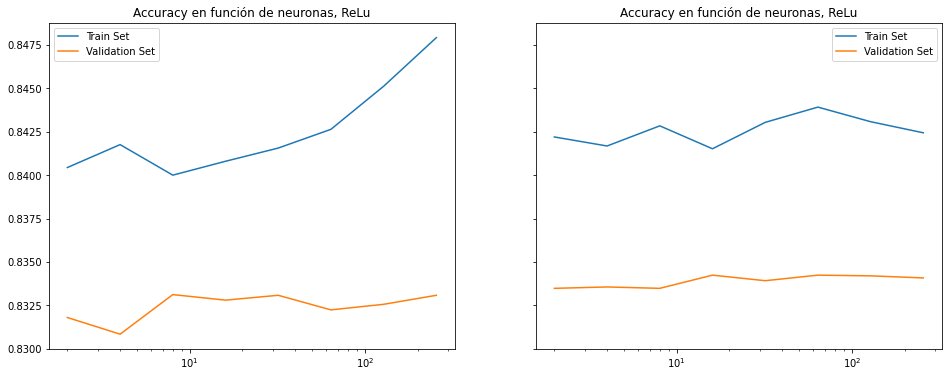

In [ ]:
# Gráficos de accuracy en función de las neuronas
r_neurons = np.loadtxt('r_neurons')

fig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(r_neurons[:,0],r_neurons[:,1])
axs[0].plot(r_neurons[:,0],r_neurons[:,2])
axs[1].plot(r_neurons[:,0],r_neurons[:,3])
axs[1].plot(r_neurons[:,0],r_neurons[:,4])
axs[0].set_title("Accuracy en función de neuronas, ReLu")
axs[0].legend(['Train Set','Validation Set'])
axs[1].set_title("Accuracy en función de neuronas, ReLu")
axs[1].legend(['Train Set','Validation Set'])
axs[0].set_xscale('log')

**Comentarios:**

Se puede ver que para la red con función de activación ReLu, se tiene que a medida aumenta el número de neuronas tiende a aumentar el accuracy sobre el train set pero no así en el validation set, lo que puede ser caso de posible sobreajuste. Para el caso de la red entrenada con tanh se obtienen valores más constantes a medida que aumentan las neuronas, de lo que puede concluir que existe menos posibilidad de sobreajuste.


#### 3.e Pesos de la red

Obtenga los pesos de la red entrenada a completitud anteriormente usando el método `.get_weights` y grafique un histograma. Note que para cada capa se obtienen por separado los pesos de los datos y del intercepto. Así, en el índice 0 obtenemos los pesos de los datos de entrada, en el 1 los pesos del intercepto de entrada, en el 2 los pesos de la capa oculta y en el 3 los pesos del intercepto de capa oculta.  Solo se requiere graficar el primero.

Compare luego ese histograma con el obtenido al graficar los pesos de una red sin entrenar como muestra el código. Discuta lo que observa.


In [ ]:
# Ajuste por ReLu, sin Entrenar
untrained = Sequential()
untrained.add(Dense(32, activation='relu'))
untrained.add(Dense(1,activation='sigmoid'))
untrained.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
untrained.fit(x_tr,y_tr,epochs=0)
untrained.build(x_tr.shape) 

In [ ]:
# Ajuste por ReLu, con Mejor número de Neuronas
red_relu2 = Sequential()
red_relu2.add(Dense(32, activation = 'relu'))
red_relu2.add(Dense(1, activation = 'sigmoid'))
red_relu2.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_relu2 = red_relu2.fit(x_tr, y_tr, epochs = 15,verbose = False , validation_data = (x_val, y_val))

Text(0.5, 1.0, 'Histograma de pesos entrenados')

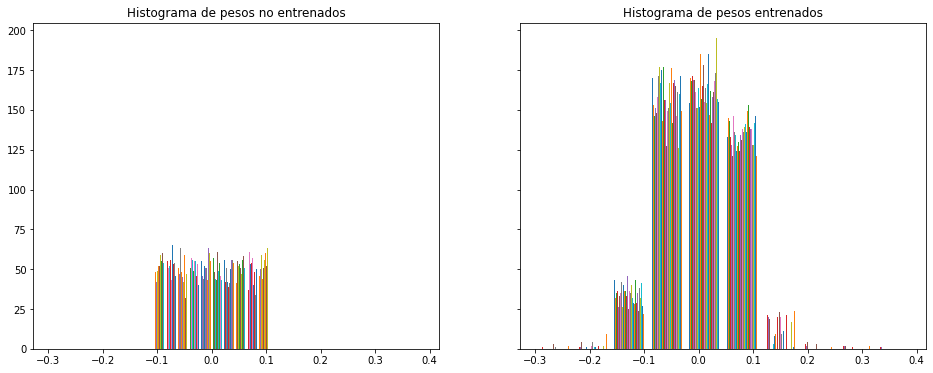

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].hist(untrained.get_weights()[0])
axs[1].hist(red_relu2.get_weights()[0])
axs[0].set_title("Histograma de pesos no entrenados")
axs[1].set_title("Histograma de pesos entrenados")

**Comentarios:**

En los histogramas se puede ver que los pesos no entrados son practicamente uniformes y se encuetran en un rango cerrado de [-0.1, 0.1]. Por otro lado, los pesos entrenados son muy diferentes, si bien se mantienen practicamente en el mismo rango, pero son mayores y en menor cantidad se distribuyen fuera del rango mencionado. Esto es producto de los que los pesos se ajustaron para mejorar la predicción.

#### 3.f Extreme Learning Machine (**Opcional**)

En esta pregunta implentaremos una _extreme learning machine_ o ELM. Este modelo puede asimilarse a una red neuronal como la entrenada anteriormente, pero donde los pesos que conectan los _input_ y la capa oculta no son entrenables. Podemos realizar esto manualmente en algunos casos o utilizando igualmente keras como muestra el código. Entrene una ELM y compare los tiempos de entrenamientos y desempeños obtenidos para redes con el mismo número de neuronas. Compare también el número de parámetros entrenable respecto redes densas del mismo tamaño.

Pruebe un par de tamños de red distintos, considerando la cantidad de parámetros libres de los modelos en cuestión y comente.

In [41]:
ELM = Sequential()
ELM.add(Dense(512, activation = 'relu', trainable = False))
ELM.add(Dense(1, activation= 'sigmoid'))
ELM.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_ELM = ELM.fit(x_tr, y_tr, epochs = 15, verbose = False, validation_data = (x_val, y_val))

In [42]:
# Resumen del modelo
resultados_ELM = history_ELM.history
ELM.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               256512    
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 513       
Total params: 257,025
Trainable params: 513
Non-trainable params: 256,512
_________________________________________________________________


In [43]:
# Ajuste por ReLu 512
red_relu3 = Sequential()
red_relu3.add(Dense(512, activation = 'relu'))
red_relu3.add(Dense(1, activation = 'sigmoid'))
red_relu3.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_relu3 = red_relu3.fit(x_tr, y_tr, epochs = 15,verbose = False, validation_data = (x_val, y_val))

In [44]:
# Resumen del modelo
resultados_relu3 = history_relu3.history
red_relu3.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 512)               256512    
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 513       
Total params: 257,025
Trainable params: 257,025
Non-trainable params: 0
_________________________________________________________________


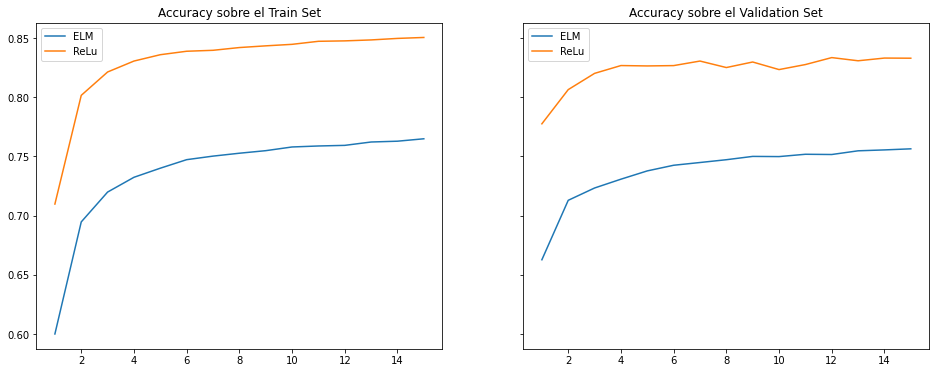

In [45]:
# Gráfico
fig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados_ELM['accuracy'])
axs[0].plot(np.arange(1,16,1),resultados_relu3['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_ELM['val_accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_relu3['val_accuracy'])
axs[0].set_title("Accuracy sobre Train Set")
axs[0].legend(['ELM','ReLu'])
axs[1].set_title("Accuracy sobre  Validation Set")
axs[1].legend(['ELM','ReLu'])

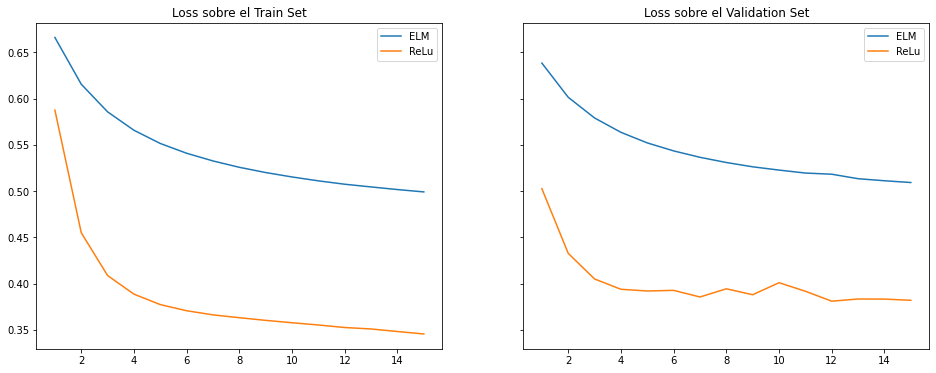

In [46]:
# Gráfico
fig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados_ELM['loss'])
axs[0].plot(np.arange(1,16,1),resultados_relu3['loss'])
axs[1].plot(np.arange(1,16,1),resultados_ELM['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados_relu3['val_loss'])
axs[0].set_title("Loss sobre el Train Set")
axs[0].legend(['ELM','ReLu'])
axs[1].set_title("Loss sobre  Validation Set")
axs[1].legend(['ELM','ReLu'])

**Comentarios:**

Se puede ver que el desempeño es mejor para el caso ReLu, donde se entrenan todos los parámetros. Debido a que en ELM se entrenan menos parámetros tiene un tiempo de entrenamiento menor. De todas formas, se puede ver que el ajuste mediante ELM tiende a parecerse a la red ReLu, donde se obtienen score relativamente cercas. Por último aclarar que de todas formas entrenar un método ELM es mejor, en este caso, que una regresión lineal.



#### 3.g Autoencoders (**Opcional**)

Otra aproximación muy ingeniosa para mejorar el desempeño de algunos modelos es el uso de autoencoders. Comente brevemenete sobr que realiza un autoencoder y sobre por qué no necesita conocer el target para entrenarse.

Esta característica de los autoencoders han permitido mejroar drásticamente muchas aplicaciones relaes donde se tienen enormes cantidades de datos sin target y menos datos ya etiquetados (por ejemplo, en reconocimientos de imágenes google tiene acceso a una cantidad en la práctica ilimitada de fotos de sus usuarios pero muy pocas fotos etiquedatas en comparación), aprendiendo representaciónes relevantes de datos y luego transfiriendo ese conocimiento. En esta pregunta utilizaremos un autoencoder para tratar de mejorar el desempeño de la red neuronal densa.

Para esto primero entrenaremos una red neuronal densa quet tienecomo inpunt y target nuestro `x_tr`. Una vez entrenada esa red, extraeremos sus pesos de la capa escondida para obtener nuestra capa encoder y nuestra capa decoder. Finalmente, utilizaremos nuestra capa de encoding como la primera capa de un nuevo modelo (más pequeño), el cual luego entrenaremos sin modificar los pesos de la capa encoding.

Note que este procedimiento también puede hacerse como un pre procesamiento de los datos, sin embargo les propongo esta manera pues pone en evidencia el proceso de transfer learning que comentabamos anteriormente.

In [51]:
autoencoder = Sequential()
autoencoder.add(Dense(512, activation = 'relu'))
autoencoder.add(Dense(x_tr.shape[1]))
autoencoder.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_auto = autoencoder.fit(x_tr, x_tr, epochs = 15,verbose = False, validation_data = (x_val, x_val))

In [52]:
# Obtener capas
encoder = autoencoder.layers[0]
decoder = autoencoder.layers[1]

In [54]:
# Crear el nuevo modelo
new_model = Sequential()
new_model.add(encoder)
new_model.layers[0].trainable = False
new_model.add(Dense(512, activation= 'relu'))
new_model.add(Dense(1, activation='sigmoid' ))

new_model.compile('sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_newmodel = new_model.fit(x_tr, y_tr, epochs = 15,verbose = False, validation_data = (x_val, y_val))

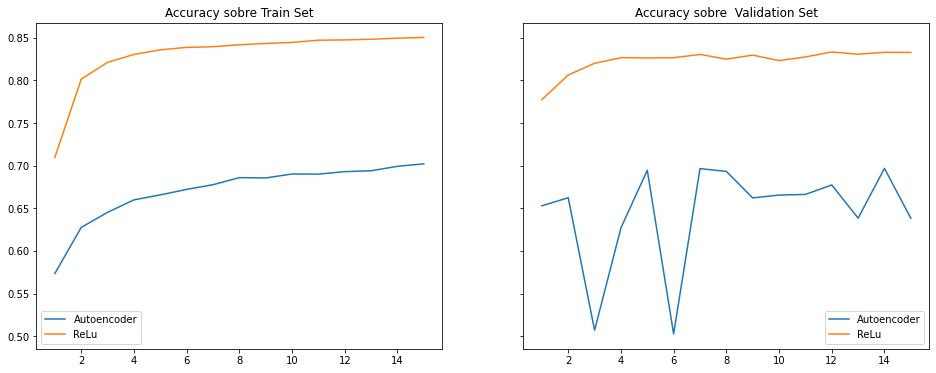

In [55]:
resultados_auto = history_newmodel.history

# Gráfico
fig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados_auto['accuracy'])
axs[0].plot(np.arange(1,16,1),resultados_relu3['accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_auto['val_accuracy'])
axs[1].plot(np.arange(1,16,1),resultados_relu3['val_accuracy'])
axs[0].set_title("Accuracy sobre Train Set")
axs[0].legend(['Autoencoder','ReLu'])
axs[1].set_title("Accuracy sobre  Validation Set")
axs[1].legend(['Autoencoder','ReLu'])

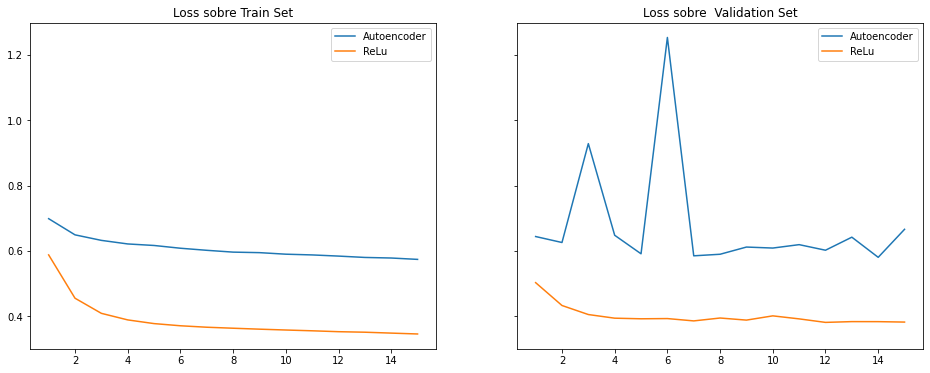

In [56]:
# Gráfico
fig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True,sharex=True)

axs[0].plot(np.arange(1,16,1),resultados_auto['loss'])
axs[0].plot(np.arange(1,16,1),resultados_relu3['loss'])
axs[1].plot(np.arange(1,16,1),resultados_auto['val_loss'])
axs[1].plot(np.arange(1,16,1),resultados_relu3['val_loss'])
axs[0].set_title("Loss sobre Train Set")
axs[0].legend(['Autoencoder','ReLu'])
axs[1].set_title("Loss sobre  Validation Set")
axs[1].legend(['Autoencoder','ReLu'])

¿Cuál es el factor de compresión (la representación que induce el autoencoder frente a la representación original)? ¿Cómo considera los resultados tomando en cuenta que en la práctica el nuevo modelo aprende con muchos menos atributos, si bien estos atributos fueron entrenados por otro modelo?

**Comentarios:**

- Para la data en cuestión, se puede ver que el desempeño por autoencoders no mejora el aprendizaje del modelo. 
- Los parámetros se reducen de forma considerable, pero no ayudan a mejorar la predicción. Creo que los resultados todavía son aceptable, pero se deberia probar más casos, es decir, quizas si se cambia la cantidad de neuronas puede funcionar mejor.



#### 3.h Bagging (**Opcional**)

Crearemos ahora un ensamblado utilizando la técnica de _Bagging_, ensamblando las predicciones de distintos árboles para predecir el resultado. 
Explique brevemente el procedimiento realizado por _Bagging_, en particular por qué los distintos árboles no se entrenan idénticamente y el significado de los parámetros que aparecen en el código. 

**Bagging**

En lugar de ajustar un único árbol, se ajustan `n_estimators` árboles en parelelo sobre subconjuntos aleatorios del dataset original. En cada nueva predicción, todos los árboles que forman el ensamblado participan aportando en la predicción. Como valor final, se toma el promedio de todos los árboles. Entrenar los arboles con subconjuntos aleatorios del conjunto original disminuye la varianza del estimador.

Variables:
- `n_estimator` corresponde al número de learner base en el ensamblado.
- `max_samples` es el número de muestras a extraer de X para entrenar cada estimador.
- `max_features` es el número de caracteristicas a extraer de X para entrenar cada estimador.

In [61]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20),
                        n_estimators = 100,
                        max_samples = 0.5,
                        max_features = 0.7)
bag.fit(x_tr,y_tr)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=20,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

In [62]:
pred_bag = bag.predict(x_val)
print('Se obtiene un score de',bag.score(x_val,y_val))

Se obtiene un score de 0.79392


#### 3.i AdaBoost

Adaptative Boosting o AdaBoost es otro meta-algoritmo que crea ensamblados a partir de modelos más simples. Entrene un modelo de AdaBoost con estimador "pequeño", por ejemplo puede usar un árbol, una regresión lineal u otros modelos de `sklearn` y un límite de estimadores (`n_estimators`) de a lo menos 200.

Calcule su _accuracy_ y comparelo con los demás métodos.

In [65]:
from sklearn.ensemble import AdaBoostClassifier

ada_tree = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                              n_estimators = 200)
ada_tree.fit(x_tr,y_tr)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [66]:
print('Se obtiene un score de',ada_tree.score(x_val,y_val))

Se obtiene un score de 0.8274


**Comentarios:**

Se puede ver que en general los ensamblados entregan score bastantes buenos y similares a los obtenidos con redes neuronales. 